In [1]:
import json
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from pathlib import Path

In [4]:
current_dir = Path.cwd()
project_root = current_dir.parents[1]

results_dir = project_root / "results" / "object_detection"
paths = glob(f"{results_dir}/*/*.json", recursive=True)


In [5]:
paths

['/Users/mac/Developer/VScode/Olive Pest Detector/results/object_detection/TFA_fc_FasterRCNN/results.json',
 '/Users/mac/Developer/VScode/Olive Pest Detector/results/object_detection/TFA_cos_FasterRCNN_scale20/results.json',
 '/Users/mac/Developer/VScode/Olive Pest Detector/results/object_detection/Full_Finetune_FasterRCNN/results.json',
 '/Users/mac/Developer/VScode/Olive Pest Detector/results/object_detection/TFA_fc_FasterRCNN_Augmented/results.json']

In [6]:
df = pd.DataFrame()
for path in paths:
    with open(path, "r") as f:
        data = json.load(f)
    # Extract model name from path
    model_name = os.path.basename(os.path.dirname(path))
    temp_df = pd.DataFrame(data)
    temp_df['model_name'] = model_name
    df = pd.concat([df, temp_df], ignore_index=True)
df

,k,map_mean,map_std,map_50_mean,map_50_std,map_75_mean,map_75_std,model_name
0,1,0.032916,0.012778,0.080806,0.025899,0.019592,0.010808,TFA_fc_FasterRCNN
1,2,0.063386,0.018745,0.147110,0.034894,0.043440,0.021478,TFA_fc_FasterRCNN
2,3,0.095889,0.023670,0.205081,0.042959,0.075311,0.027013,TFA_fc_FasterRCNN
3,5,0.143681,0.014926,0.281000,0.027572,0.134959,0.017652,TFA_fc_FasterRCNN
4,10,0.189228,0.014689,0.344912,0.024679,0.191784,0.020398,TFA_fc_FasterRCNN
5,1,0.049720,0.015083,0.117909,0.031016,0.032737,0.015459,TFA_cos_FasterRCNN_scale20
6,2,0.086147,0.013810,0.185352,0.025932,0.067624,0.019781,TFA_cos_FasterRCNN_scale20
7,3,0.111583,0.019703,0.231443,0.034915,0.094707,0.026248,TFA_cos_FasterRCNN_scale20
8,5,0.150577,0.016600,0.286150,0.030423,0.146125,0.022059,TFA_cos_FasterRCNN_scale20
9,10,0.199467,0.016227,0.353246,0.029395,0.207790,0.016843,TFA_cos_FasterRCNN_scale20


Generating Accuracy Plot for FSOD


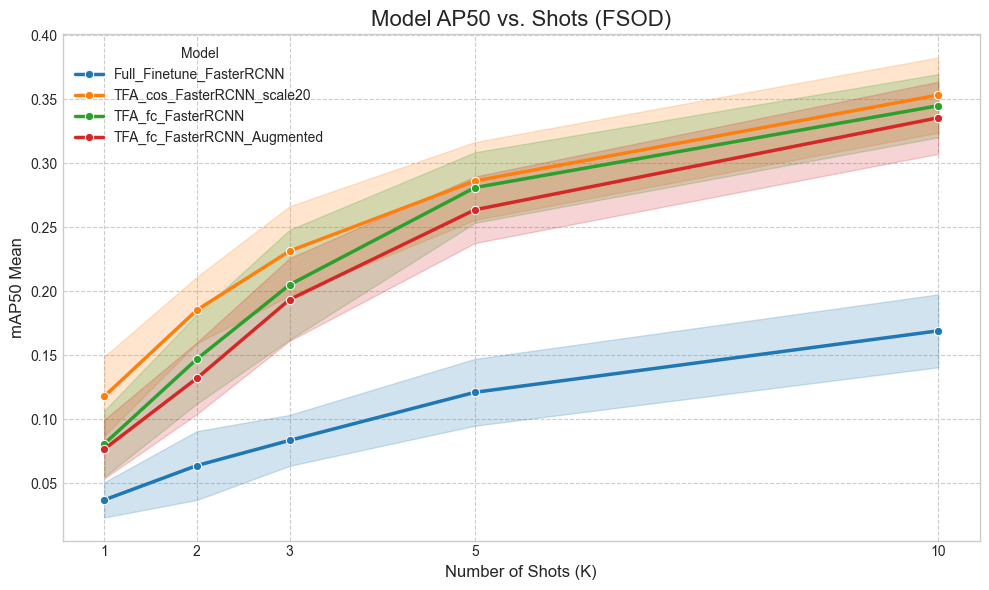

In [10]:
def plot_results(df, results_dir):
    """Generates and saves a comparison plot for accuracy with confidence intervals."""
    print(f"Generating Accuracy Plot for FSOD")
    if df.empty:
        print("No results to plot.")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # --- FIX: Create a consistent color mapping to sync lines and fills ---
    # 1. Determine a consistent color mapping for the models.
    unique_models = sorted(df['model_name'].unique())
    palette = sns.color_palette("tab10", len(unique_models))
    color_map = dict(zip(unique_models, palette))

    # 2. Use this explicit mapping in the lineplot.
    sns.lineplot(
        data=df,
        x='k',
        y='map_50_mean',
        hue='model_name',
        hue_order=unique_models,
        palette=color_map,
        marker='o',
        ax=ax,
        linewidth=2.5
    )

    # 3. Use the same mapping when drawing the confidence intervals.
    for name, group in df.groupby('model_name'):
        color = color_map[name]  # Get the specific color for the current model
        ax.fill_between(
            group['k'],
            group['map_50_mean'] - group['map_50_std'],
            group['map_50_mean'] + group['map_50_std'],
            color=color,  # Explicitly set the fill color to match the line
            alpha=0.2
        )

    ax.set_xlabel("Number of Shots (K)", fontsize=12)
    ax.set_ylabel("mAP50 Mean", fontsize=12)
    ax.set_title(f"Model AP50 vs. Shots (FSOD)", fontsize=16)

    # Update legend to use the consistent ordering
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Model')

    ax.grid(True, which='both', linestyle='--')
    ax.set_xticks([1,2,3,5,10])
    plt.tight_layout()
    plt.show()

plot_results(df, results_dir)